# Clustering data with Lloyd's algorithm
This notebook contains the first task for assignment 3 of the course "Mining Massive Data" course in 2022S at the University of Vienna.
It includes an implementations of K-Means with Lloyd's algorithm as well as a comparison to scipy's cluster labels, the predefined cluster labels and a visualization of the algorithm's convergence.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA

## Loading the Data
A dataset from the KDD Cup 2004 is used for validation and evaluation of the algorithm, where
a protein matching problem was targeted. More information and the dataset can be found here: https://www.kdd.org/kdd-cup/view/kdd-cup-2004/Data


The first element of each line is a BLOCK ID that denotes to which native sequence this example belongs. Since there are 153 distinct values, the true number of clusters is considered to be 153.

In [5]:
data = pd.read_csv('bio_train.csv', header=None)
labels = data[0].to_numpy()
data = pd.DataFrame(StandardScaler().fit_transform(data[data.columns[3:]]), columns = data.columns[3:])
data = data.to_numpy()

## Lloyd's Algorithm
The implementation of Lloyd's algorithm consists of three parts: Initializing the cluster centers, assigning each data point to a cluster and re-calculating the cluster centers. Each point is assigned to the cluster whose center is at minimum distance. The assignment and update step are repeated until the algorithm converges, i.e. no changes occur in the cluster centers for at least one iteration.

The cluster centers are initially set to the first k data points. Even though k-means is guaranteed to converge, a maximum number of iterations was set in order to limit the runtime of the algorithm for testing. For the KDD set the algorithm was tested on, this limit is more than sufficient but different datasets might require a higher number of iterations, which can easily be changed with the parameter "max_iter".

In [6]:
def lloyds_algorithm(data, k=153, max_iter=1000):

  # initialize cluster centers
  if len(data) < k:
    raise ValueError("more cluster centers than data points")
  
  cluster_centers = data[:k]
  cluster_assignments = np.zeros(len(data))
  n_cluster_changes = []
  n_iterations = max_iter
  
  for j in range(max_iter):
    previous_assignments = cluster_assignments.copy()

    # cluster assignments
    dists = cdist(data, cluster_centers, 'euclidean')
    cluster_assignments = np.argmin(dists, axis=1)

    # cluster updates
    cluster_centers = np.asarray([np.mean(data[np.where(cluster_assignments == i)], axis=0) for i, c in enumerate(cluster_centers)])

    n_cluster_changes.append(np.count_nonzero(cluster_assignments != previous_assignments))
    if n_cluster_changes[-1] == 0:
      n_iterations = j + 1
      break

  return cluster_centers, cluster_assignments, n_iterations, n_cluster_changes

In [13]:
runtime = time.time()
cluster_centers, cluster_assignments, n_iterations, n_cluster_changes = lloyds_algorithm(data, k=153)
runtime = time.time() - runtime
print(runtime)

519.1377332210541


### Evaluation
We evaluated the clustering against the predefined labels in the first column of the dataset using sklearn's implementation of normalized mutual information. The first three columns of the dataset were dropped in order to not influence the clustering . The NMI scores between the clustering obtained by the algorithm and the predefined labels was about 0.19 for most configurations tested by us, i.e. with or without shuffling, scaling to unit variance and including some of the dropped columns. Considering that the NMI ranges from 0 to 1, this score indicates some similarity between the clusterings but not a very high one. The same NMI scores were obtained when comparing the labels to scipy.cluster.vq.kmeans2 with fixed inital cluster centers.

In [ ]:
k = 153
n_runs = 5
avg_runtime = 0
n_iterations = 0

for i in range(n_runs):
  runtime = time.time()
  cluster_centers, cluster_assignments, n_iterations, n_cluster_changes = lloyds_algorithm(data)
  avg_runtime += time.time() - runtime

avg_runtime /= n_runs
print("The average runtime of the vanilla Lloyd's algorithm was %d seconds." % avg_runtime)
print("It needed %d iterations for convergence and performed %d distance computations." % (n_iterations, k * len(data) * n_iterations))

The average runtime of the vanilla Lloyd's algorithm was 187 seconds.
It needed 147 iterations for convergence and performed 22491 distance computations.


In [ ]:
nmi = normalized_mutual_info_score(labels, cluster_assignments)
print("The NMI of the vanilla Lloyd's algorithm was %f." % nmi)

The NMI of the vanilla Lloyd's algorithm was 0.188847.


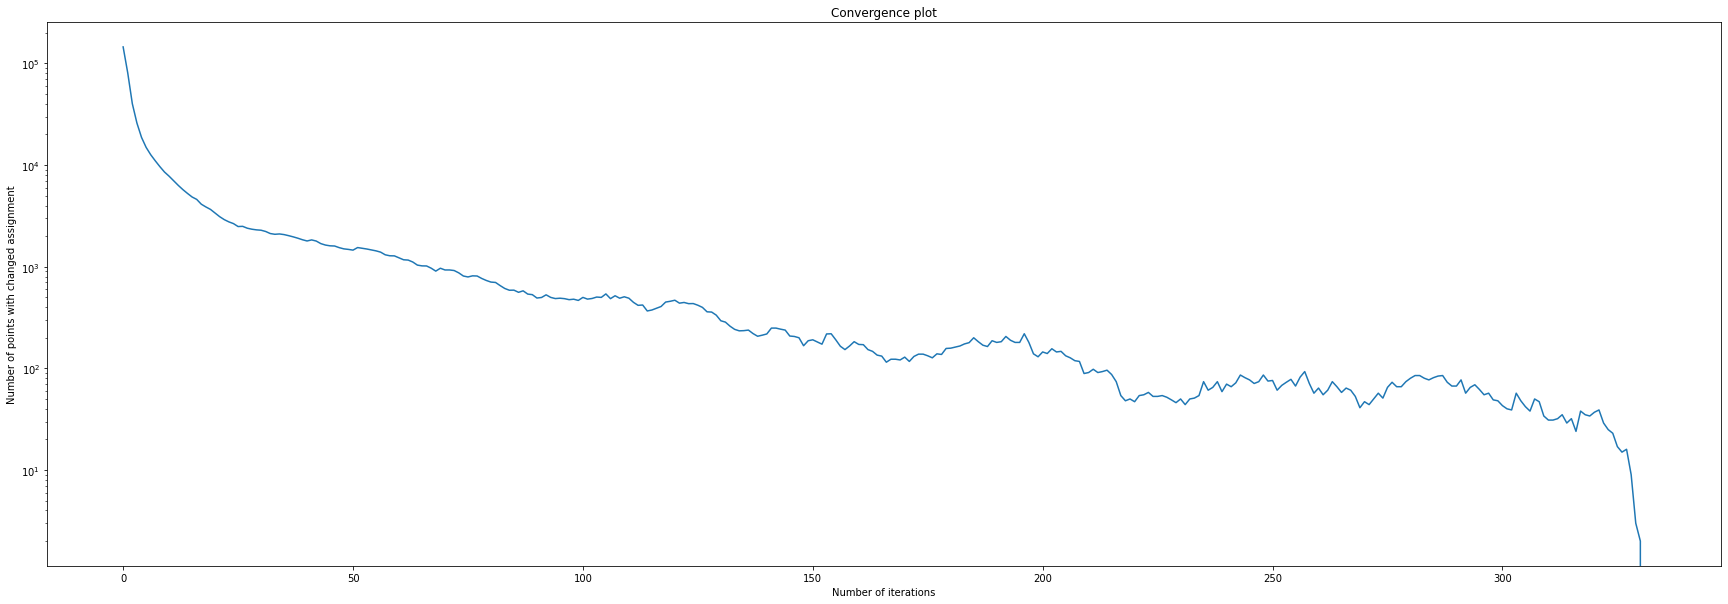

In [ ]:
plt.figure(figsize=(30, 10))
plt.title("Convergence plot")
plt.xlabel("Number of iterations")
plt.ylabel("Number of points with changed assignment")
plt.semilogy(range(n_iterations), n_cluster_changes)
plt.show()

Runtime measurements were conducted on Google Colaboratory. The average runtime of the algorithm over five runs was 187 seconds. In an example run, 147 iterations were needed for convergence and 22491 distances between pairs of data points were computed. After normalizing the data, runtimes increased to about 400 second per run.

### PCA Visualizations

We reduce the clusters found with Lloyd's algorithm, scipy's K-Means and the pre-defined clusters to two dimensions with a principal component analysis and plot them.

In [10]:
def plot_pca(labels, data_pca, title):
    
    label_vals = np.unique(labels)
    clusters = []
    
    for l in label_vals:
      cluster = data_pca[np.where(labels == l)]
      clusters.append(cluster)
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel("first principal component")
    plt.ylabel("second principal component")
    
    for c in clusters:
      plt.scatter(c[:,0], c[:,1])
    plt.show()

In [8]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

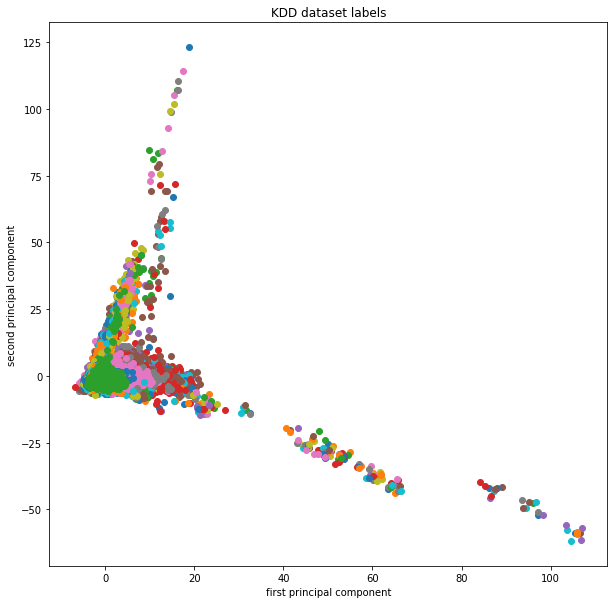

In [19]:
plot_pca(labels, data_pca, "KDD dataset labels")

In [18]:
_, cluster_assignments, _, _ = lloyds_algorithm(data, k=153)

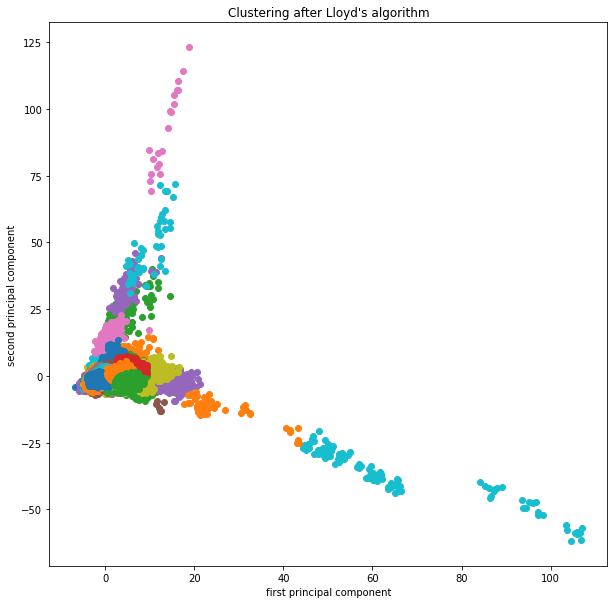

In [20]:
plot_pca(cluster_assignments, data_pca, "Clustering after Lloyd's algorithm")

In [15]:
initial_centroids = data[:153]
_, scipy_label = kmeans2(data, initial_centroids, minit='matrix')

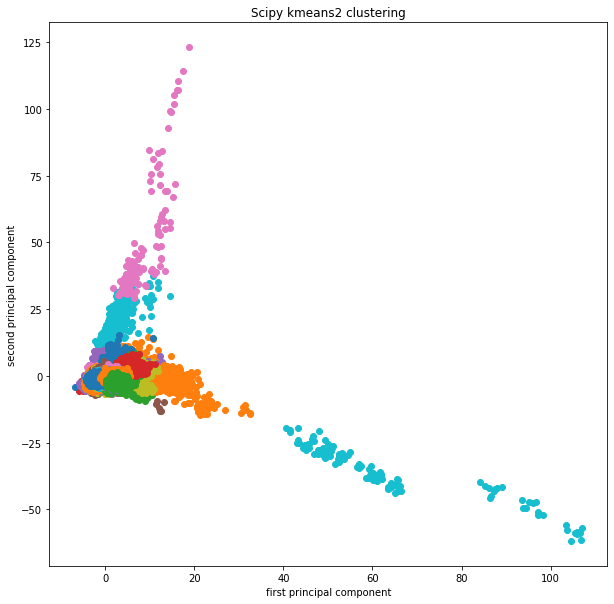

In [17]:
plot_pca(scipy_label, data_pca, "Scipy kmeans2 clustering")

We assume that the structure of the predefined clustering is different from the structure of clusters obtained with k-means in general and not due to any errors or specifics of our implementation. The plot "Clustering after Lloyd's algorithm" suggests that the pre-defined clusters are not always one continuous area but that points from different clusters are interspersed, which is by definition not possible with k-means. However, the visualizations should be interpreted with caution as they are strongly reduced in dimensionality.